# Metaphor Detection
## michelle.carney@berkeley.edu
### NLP Info 256, Prof Marti Hearst, School of Information, UC Berkeley

# Background

Metaphors, like similes, are easy for humans to understand but difficult for computers to identify. Unlike similes, they do not have a consistent structure: they can be adjacent to the words they modify or span an entire text. They do not use a set of distinguishing words – virtually any word can be a metaphor at the discretion of the author. Even some of the most forefront research on this topic only achieves 80% accuracy with metaphor detection (Tsvetkov, Boytsov, Gershman, Nyberg, & Dyer, 2014). For the scope of this project, we were interested in applying the techniques we learned in this course to metaphor detection in order to better understand what is classified as a metaphor. 

There are many types of metaphors, but we are most interested in trite metaphors. We have defined “trite metaphors” to be phrases of words that are used in everyday speech, and that have adjacent modifiers – whether it is adjective noun (i.e., “boiling rage”) or subject verb object (i.e., “excitement filled street”), similar to Tsvetkov et al. We will be excluding metaphors that are overarching throughout a text.


# Description of Data

For this project, we used a list of subject-verb-object and adjective-noun metaphors and non-metaphors from Tsvetkov et. al (Tsvetkov, Github/metaphor, 2014) to create a feature vectors and classifiers. One of the most difficult tasks for this project was finding examples of non-metaphors, but we were fortunate that Tsvetkov et. al provided examples (adj-n metaphors n= 100, adj-n nonmetaphors n=100, subj-v-obj n=111, subj-v-obj n=111). We also used the recently published Metanet (n=1184 sample metaphor high-level categories) (Lakoff, 2016), a list of children’s metaphors (n=71 sample metaphors) (yourdictionary.com, 2016), and a sample article on semantic meaning in the brain (Sample, 2016) for testing the metaphor detection. Michelle used BeautifulSoup to scrape the 1,184 high-level metaphor categories from Metanet, and the sample children’s metaphors. Metanet was also tested in the feature vectors and classifiers, but it often was too high level and proved to be less helpful than the Tsvetkov provided metaphor examples.


In [180]:
##all the imports...
import re
import math
import string
import nltk
import pprint
import matplotlib
import pandas as pd
import numpy as np
from nltk import word_tokenize
sent_tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')
from collections import Counter
from __future__ import division
from nltk.collocations import *
import string, random
from nltk.corpus import brown
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk import bigrams
from nltk import collocations
from nltk import trigrams
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.corpus import names
import random
from collections import defaultdict
from difflib import SequenceMatcher

## Start by loading the .csv files and setting the columns.
For these .csv files, downloaded from https://github.com/ytsvetko/metaphor inputs and saved as .csv with the first row added as "sample"

Metanet was scraped from  https://metaphor.icsi.berkeley.edu/pub/en/index.php/Category:Metaphor (see code in metanetscrape.py) and saved as a .csv

In [2]:
df_anmet = pd.read_csv("an_mets.csv", low_memory=False)
df_anmet.head()

,sample
0,angry welt
1,bald assertion
2,bare outline
3,black humor
4,blind alley


In [3]:
#Adjective-noun metaphors from https://github.com/ytsvetko/metaphor
df_anmet = pd.read_csv("an_mets.csv", low_memory=False)
df_anmet['metaphor'] = 1
df_anmet['an'] = 1
df_anmet['svo'] = 0
df_anmet['metanet'] = 0
df_anmet.head()
len(df_anmet)

100

In [4]:
##Adjective-noun NONmetaphors from https://github.com/ytsvetko/metaphor
df_annonmet = pd.read_csv("an_nonmets.csv", low_memory=False)
df_annonmet['metaphor'] = 0
df_annonmet['an'] = 1
df_annonmet['svo'] = 0
df_annonmet['metanet'] = 0
df_annonmet.head()
len(df_annonmet)

100

In [5]:
#Subj-Verb-Obj metaphors from https://github.com/ytsvetko/metaphor
df_svomet = pd.read_csv("svo_mets.csv", low_memory=False)
df_svomet['metaphor'] = 1
df_svomet['an'] = 0
df_svomet['svo'] = 1
df_svomet['metanet'] = 0
df_svomet.head()
len(df_svomet)

111

In [6]:
#Subj-Verb-Obj NONmetaphors from https://github.com/ytsvetko/metaphor
df_svononmet = pd.read_csv("svo_nonmets.csv", low_memory=False)
df_svononmet['metaphor'] = 0
df_svononmet['an'] = 0
df_svononmet['svo'] = 1
df_svononmet['metanet'] = 0
df_svononmet.head()
len(df_svononmet)

111

In [166]:
#Metanet scraped from  https://metaphor.icsi.berkeley.edu/pub/en/index.php/Category:Metaphor
#see metanetscrape.py for scraping code
df_metanet = pd.read_csv("metanet.csv", low_memory=False)
df_metanet['metaphor'] = 1
df_metanet['an'] = 0
df_metanet['svo'] = 0
df_metanet['metanet'] = 1
df_metanet.head()
# len(df_metanet)

df_metanet.head()

,sample,metaphor,an,svo,metanet
0,ability to evaluate government is ability to see,1,0,0,1
1,ability to evaluate is ability to see,1,0,0,1
2,ability to know is ability to see,1,0,0,1
3,abusive political leaders are physical bullies,1,0,0,1
4,accepting is swallowing,1,0,0,1


## We will use these examples to inform our decisions on what to test

# Calculating Wordnet Distance
Our first hypothesis was that words that were “far away” from each other in Wordnet were more likely to be metaphors. In order to calculate the distance, we used path_similarity, wup_similarity, and lch_similarity. We quickly discovered that distances were not reliable predictors even within small sample tests. For example, in the metaphor “he is the head of the government” – if we take the key part of the metaphor (“head” and “government”) – it was difficult to get the correct synset of “head” and “government” without hand selecting the results, and hand selecting the parts of the sentence to compare similarity to.


In [29]:
print('wn.synsets("head")[0].definition():', wn.synsets('head')[0].definition())
print('wn.synsets("government")[0].definition():', wn.synsets('government')[0].definition())
print('wn.synsets("head")[3].definition():', wn.synsets('head')[3].definition())

wn.synsets("head")[0].definition(): the upper part of the human body or the front part of the body in animals; contains the face and brains
wn.synsets("government")[0].definition(): the organization that is the governing authority of a political unit
wn.synsets("head")[3].definition(): a person who is in charge


We need the 3rd gloss of the word head in order to complete the metaphor "He is the head of the government" - let us calculate the distance from the first glosses of each

In [13]:
#http://stackoverflow.com/questions/22031968/how-to-find-distance-between-two-synset-using-python-nltk-in-wordnet-hierarchy
print('path: ' + str(wn.synsets('head')[0].path_similarity(wn.synsets('government')[0])))
print('wup: ' + str(wn.synsets('head')[0].wup_similarity(wn.synsets('government')[0])))
print('lch: ' + str(wn.synsets('head')[0].lch_similarity(wn.synsets('government')[0])))

path: 0.07692307692307693
wup: 0.14285714285714285
lch: 1.072636802264849


In [24]:
print('path: ' + str(wn.synsets('head')[3].path_similarity(wn.synsets('government')[0])))
print('wup: ' + str(wn.synsets('head')[3].wup_similarity(wn.synsets('government')[0])))
print('lch: ' + str(wn.synsets('head')[3].lch_similarity(wn.synsets('government')[0])))

path: 0.08333333333333333
wup: 0.15384615384615385
lch: 1.1526795099383855


As we can see from these similarities, there is not a big difference between the two scores. It is difficult enough to find the key words, then find the correct glosses of the words, so let us try another approach

# Using CountVectorizer and Logistic Regression
Next, we tried using CountVectorizer with logistic regression, similar to the technique we used in the Kaggle assignment. The idea behind this technique is that if we have some features from the Tsvetkov et. al metaphor (and non-metaphor), we could try to predict if certain phrases were metaphors on the bigram or trigram level (the same format as the training data). This worked the best with Logistic Regression, accurately predicting the holdout set at 94% at the highest, but this may have also been because of the small sample size of the Tsvetkov dataset (n=422). It over fitted its predictions on datasets like the Children’s metaphors, Metanet, and the sample article, predicting at least 1 metaphor per sentence, even with stop words and punctuation removed.


In [167]:
#combine alll of the csvs into one df
frames = [df_anmet, df_annonmet, df_svomet, df_svononmet, df_metanet]
df_combo = pd.concat(frames)
df_combo.reset_index(drop=True, inplace=True)
df_combo.shape
df_combo.replace(to_replace='none', value="")
# tokenizer = RegexpTokenizer(r'\w+')
# word_list = tokenizer.tokenize(line)
filtered_words = [word for word in word_list if word not in stopwords.words('english')]
df_combo.replace(to_replace='is', value="")
stop = ['*none', '.', 'is']
df_combo['sample'].apply(lambda x: [item for item in x if item not in stop])
df_combo[50:55]

,sample,metaphor,an,svo,metanet
50,silky voice,1,1,0,0
51,slim picking,1,1,0,0
52,slimy salesman,1,1,0,0
53,smoky alto,1,1,0,0
54,smooth operation,1,1,0,0


In [102]:
random_index = np.random.permutation(df_combo.index)
df_combo.ix[random_index, ['sample', 'metaphor', 'an', 'svo', 'metanet']]
df_shuffled = df_combo.ix[random_index, ['sample', 'metaphor', 'an', 'svo', 'metanet']]
df_shuffled.reset_index(drop=True, inplace=True)
len(df_shuffled)
#we are training with metanet

1606

### Break down into training, dev, and test sets

In [103]:
rows, columns = df_shuffled.shape
print("Rows:", rows)
print("Columns:", columns)
#train_size = round(rows*.6)
train_size = round(rows*.9)
#dev_size   = round(rows*.2)
dev_size   = round(rows*.1)
df_train = df_shuffled.loc[:train_size]
df_train.shape
df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)
df_dev.shape
df_test = df_shuffled.loc[dev_size+train_size:].reset_index(drop=True)
df_test.shape

Rows: 1606
Columns: 5


(0, 5)

In [104]:
# vec = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', analyzer=u'word', min_df=1, vocabulary=vocab)
# df_train = df_train.fillna("")
# df_dev = df_dev.fillna("")
# df_test = df_test.fillna("")


vec = TfidfVectorizer(ngram_range=(2, 3), token_pattern=r'\b\w+\b', analyzer=u'char', min_df=1)
df_train = df_train.fillna("")
df_dev = df_dev.fillna("")
df_test = df_test.fillna("")

In [105]:
arr_train_feature_sparse = vec.fit_transform(df_train['sample'])
arr_train_feature_sparse
arr_train_feature = arr_train_feature_sparse.toarray()
feature_labels = vec.get_feature_names()

In [106]:
arr_dev_feature_sparse = vec.transform(df_dev["sample"])
arr_dev_feature = arr_dev_feature_sparse.toarray()

In [107]:
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor']) #defining features (from reviews) and passing in Category label
logreg_predictions = logreg_model.predict(arr_dev_feature)
accuracy_score(df_dev['metaphor'], logreg_predictions)

0.87577639751552794

In [108]:
feature_sum = arr_train_feature.sum(axis=0)   #sum the counts of each feature

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()
df_feature_sum.sort('counts', ascending=False)[0:10]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,counts
s,55.662982
in,54.467085
i,51.888798
is,51.177330
ti,50.050967
on,49.822128
a,49.635928
is,45.074299
is,44.819593
re,42.103625


In [110]:
with open("sciencearticle_line.txt", "r") as testset:
    filtered_words = []
    testmeta = []
    testmeta1 = []
    word_list = ''
    for line in testset:
        word_list = line.split()
        filtered_words = [word for word in word_list if word not in stopwords.words('english')]
        testmeta1.append(' '.join(x) for x in trigrams(filtered_words))
df_test = pd.DataFrame(testmeta1)
# df_test = df_test.ix[:, 0:6]
# df_test.columns = ['sample0', 'sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6']
df_test = df_test.fillna("")
df_test

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Scientists created “atlas,created “atlas brain”,“atlas brain” reveals,brain” reveals meanings,reveals meanings words,meanings words arranged,words arranged across,arranged across different,across different regions,different regions organ.,...,,,,,,,,,,
1,Like colourful quilt,colourful quilt laid,"quilt laid cortex,","laid cortex, atlas","cortex, atlas displays",atlas displays rainbow,displays rainbow hues,rainbow hues individual,hues individual words,individual words concepts,...,concepts convey grouped,convey grouped together,grouped together clumps,together clumps white,clumps white matter.,,,,,
2,“Our goal build,goal build giant,build giant atlas,giant atlas shows,atlas shows one,shows one specific,one specific aspect,specific aspect language,aspect language represented,"language represented brain,",...,"brain, case semantics,","case semantics, meanings","semantics, meanings words,”","meanings words,” said","words,” said Jack","said Jack Gallant,","Jack Gallant, neuroscientist","Gallant, neuroscientist University","neuroscientist University California,","University California, Berkeley."
3,No single brain,single brain region,brain region holds,region holds one,holds one word,one word concept.,,,,,...,,,,,,,,,,
4,A single brain,single brain spot,brain spot associated,spot associated number,associated number related,number related words.,,,,,...,,,,,,,,,,
5,And single word,single word lights,word lights many,lights many different,many different brain,different brain spots.,,,,,...,,,,,,,,,,
6,Together make networks,make networks represent,networks represent meanings,represent meanings word,meanings word use:,word use: life,use: life love;,life love; death,love; death taxes;,"death taxes; clouds,",...,"clouds, Florida bra.",,,,,,,,,
7,All light networks.,,,,,,,,,,...,,,,,,,,,,
8,Described “tour de,“tour de force”,de force” one,force” one researcher,one researcher involved,"researcher involved study,","involved study, atlas","study, atlas demonstrates",atlas demonstrates modern,demonstrates modern imaging,...,imaging transform knowledge,transform knowledge brain,knowledge brain performs,brain performs important,performs important tasks.,,,,,
9,"With advances, technology","advances, technology could",technology could profound,could profound impact,profound impact medicine,impact medicine fields.,,,,,...,,,,,,,,,,


In [111]:
arr_test_feature_sparse = vec.transform(df_test[0])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor0'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[1])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor1'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[2])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor2'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[3])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor3'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[4])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor4'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[5])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor5'] = logreg_predictions

arr_test_feature_sparse = vec.transform(df_test[6])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor6'] = logreg_predictions

# df_test['sum_metaphor'] = df_test[0]+df_test[1]+df_test[2]+df_test[3]+df_test[4]+df_test[5]+df_test[6]

# if sum(df_test['sum_metaphor']) >= 1:
#     df_test['sum_metaphor'] = 1
# sum(df_test['sum_metaphor'])
# #len(df_test['sum_metaphor'])
df_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,metaphor0,metaphor1,metaphor2,metaphor3,metaphor4,metaphor5,metaphor6
0,Scientists created “atlas,created “atlas brain”,“atlas brain” reveals,brain” reveals meanings,reveals meanings words,meanings words arranged,words arranged across,arranged across different,across different regions,different regions organ.,...,,,,1,1,1,1,1,1,1
1,Like colourful quilt,colourful quilt laid,"quilt laid cortex,","laid cortex, atlas","cortex, atlas displays",atlas displays rainbow,displays rainbow hues,rainbow hues individual,hues individual words,individual words concepts,...,,,,1,1,1,1,1,1,1
2,“Our goal build,goal build giant,build giant atlas,giant atlas shows,atlas shows one,shows one specific,one specific aspect,specific aspect language,aspect language represented,"language represented brain,",...,"Gallant, neuroscientist University","neuroscientist University California,","University California, Berkeley.",1,1,1,1,1,1,1
3,No single brain,single brain region,brain region holds,region holds one,holds one word,one word concept.,,,,,...,,,,1,1,1,1,1,1,1
4,A single brain,single brain spot,brain spot associated,spot associated number,associated number related,number related words.,,,,,...,,,,1,1,1,1,1,1,1
5,And single word,single word lights,word lights many,lights many different,many different brain,different brain spots.,,,,,...,,,,1,1,1,1,1,1,1
6,Together make networks,make networks represent,networks represent meanings,represent meanings word,meanings word use:,word use: life,use: life love;,life love; death,love; death taxes;,"death taxes; clouds,",...,,,,1,1,1,1,1,1,1
7,All light networks.,,,,,,,,,,...,,,,1,1,1,1,1,1,1
8,Described “tour de,“tour de force”,de force” one,force” one researcher,one researcher involved,"researcher involved study,","involved study, atlas","study, atlas demonstrates",atlas demonstrates modern,demonstrates modern imaging,...,,,,1,1,1,1,1,1,1
9,"With advances, technology","advances, technology could",technology could profound,could profound impact,profound impact medicine,impact medicine fields.,,,,,...,,,,1,1,1,1,1,1,1


Note how the predictor is predicting virtually every trigram is a metaphor.

In [112]:
with open("sciencearticle_line.txt", "r") as testset:
    filtered_words = []
    testmeta = []
    testmeta1 = []
    word_list = ''
    for line in testset:
        word_list = line.split()
        filtered_words = ' '.join([word.lower() for word in word_list if word not in stopwords.words('english')])
        testmeta1.append(filtered_words)
df_test = pd.DataFrame(testmeta1)
df_test
# df_test = df_test.ix[:, 0:6]
df_test.columns = ['sample0']
df_test = df_test.fillna("")
arr_test_feature_sparse = vec.transform(df_test['sample0'])
arr_test_feature = arr_test_feature_sparse.toarray()
logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train['metaphor'])
logreg_predictions = logreg_model.predict(arr_test_feature)
indices = [i for i, x in enumerate(logreg_predictions) if x == 0]
df_test['metaphor0'] = logreg_predictions

df_test.head()

,sample0,metaphor0
0,scientists created “atlas brain” reveals meani...,1
1,"like colourful quilt laid cortex, atlas displa...",1
2,“our goal build giant atlas shows one specific...,1
3,no single brain region holds one word concept.,1
4,a single brain spot associated number related ...,1


This also happens when we run it on the whole sentence with stopwords removed

# Using Naïve Bayes Classifier with Parts of Speech
For our next attempt, we decided to try using the Part of Speech and Naïve Bayes classifier.  We trained the nltk.NaiveBayesClassifier on the different parts of speech of each sample from the Tsvetkov et. al metaphor sample. This performed fairly well on the sample Children’s Metaphors, and accurately predicted the development set of the data 57% of the time without additional adjustments to the incorrect POS tags. Also, interestingly enough, the POS tags NN=None, JJ=1, and NN=2 (no nouns, 1 adjective, and 2 nouns) were among the top 15 features for distinguishing if a trigram was or was not a metaphor. This was the sample we showed in the demonstration showcase, and we had to reverse engineer our result from being a bag of words to highlighting metaphors in a text, which proved to be fairly difficult.


In [113]:
#open all of the files
f = open('an_mets.txt', 'r')
x = f.readlines()
an_mets = [t.rstrip() for t in x[1::]]
# an_mets = [word for word in an_mets]
f = open('an_nonmets.txt', 'r')
x = f.readlines()
an_nonmets = [t.rstrip() for t in x[1::]]
f = open('svo_mets.txt', 'r')
x = f.readlines()
svo_mets = [t.rstrip() for t in x[1::]]
f = open('svo_nonmets.txt', 'r')
x = f.readlines()
svo_nonmets = [t.rstrip() for t in x[1::]]
f = open('metanet.txt', 'r')
x = f.readlines()
metanet_mets = [t.rstrip() for t in x[1::]]

In [114]:
# nltk.pos_tag(svo_mets)
# svo_mets
POS_bucket = []
for line in svo_mets:
    for word in line:
        POS = nltk.pos_tag(word)
        POS_bucket.append(POS[0][1])
    
len(POS_bucket)

def get_pos_list_from_ngram(ngram):
    ngram_tagged = nltk.pos_tag(ngram.split())
    pos_list = [tagged_word[1] for tagged_word in ngram_tagged]
    return pos_list

get_pos_list_from_ngram("care break *none")

['NN', 'NN', 'NN']

In [150]:
def featurize_pos_list(pos_list, features):
    for pos in pos_list:
        if pos in features.keys():
            features[pos] += 1
        else:
            features[pos] = 1
    return features

def metaphor_features(wordphrase):
    features = {}
    POS_bucket = []
    wordphrase = wordphrase.lower()
    features = featurize_pos_list(get_pos_list_from_ngram(wordphrase), features)
    features['first'] = wordphrase[0]
    return features
print(str(metaphor_features('how will we do this')))  

{'PRP': 1, 'first': 'h', 'MD': 1, 'DT': 1, 'WRB': 1, 'VB': 1}


In [151]:
def create_an_data():
    an_mets_tag = [(re.sub(r'[^\w\s]','',line.lower()), 'metaphor') for line in an_mets]
    an_nonmets_tag = [(re.sub(r'[^\w\s]','',line.lower()), 'NOT metaphor') for line in an_nonmets]
    svo_mets_tag = [(re.sub(r'[^\w\s]','',line.lower()), 'metaphor') for line in svo_mets]
    svo_nonmets_tag = [(re.sub(r'[^\w\s]','',line.lower()), 'NOT metaphor') for line in svo_nonmets]
#     metanet_tag = [(re.sub(r'[^\w\s]','',line.lower()), 'metaphor') for line in metanet_mets]
    all_an = an_mets_tag + an_nonmets_tag + svo_mets_tag + svo_nonmets_tag
    
    # Randomize the order of male and female names, and de-alphabatize
    random.shuffle(all_an)
    return all_an

all_an_data = create_an_data()

In [152]:
with open("all_an_data.csv", "w") as f:
    f.write("Phrase,Label\n")
    for metaphor in all_an_data:
        f.write(metaphor[0] + "," + metaphor[1] + "\n")
        

In [153]:
# This function allows experimentation with different feature definitions
# items is a list of (key, value) pairs from which features are extracted and training sets are made
# Feature sets returned are dictionaries of features

# This function also optionally returns the names of the training, development, 
# and test data for the purposes of error checking

def create_training_sets (feature_function, items, return_items=False):
    # Create the features sets.  Call the function that was passed in.
    # For names data, key is the name, and value is the gender
    featuresets = [(feature_function(key), value) for (key, value) in items]
    
    # Divided training and testing in thirds.  Could divide in other proportions instead.
    third = int(float(len(featuresets)) / 3.0)
    
    train_set, dev_set, test_set = featuresets[0:third], featuresets[third:third*2], featuresets[third*2:]
    train_items, dev_items, test_items = items[0:third], items[third:third*2], items[third*2:]
    if return_items == True:
        return train_set, dev_set, test_set, train_items, dev_items, test_items
    else:
        return train_set, dev_set, test_set

In [154]:
train_set, dev_set, test_set = create_training_sets(metaphor_features, all_an_data)
cl = nltk.NaiveBayesClassifier.train(train_set)

In [155]:
print ("%.3f" % nltk.classify.accuracy(cl, dev_set))
cl.show_most_informative_features(15)

0.550
Most Informative Features
                   first = 'g'            NOT me : metaph =      3.1 : 1.0
                   first = 'p'            NOT me : metaph =      3.1 : 1.0
                     VBP = 1              NOT me : metaph =      2.7 : 1.0
                      NN = 3              metaph : NOT me =      2.4 : 1.0
                      VB = 1              NOT me : metaph =      2.4 : 1.0
                   first = 'd'            metaph : NOT me =      2.1 : 1.0
                   first = 'r'            NOT me : metaph =      1.7 : 1.0
                   first = 'f'            NOT me : metaph =      1.6 : 1.0
                      NN = 2              NOT me : metaph =      1.6 : 1.0
                      RB = 1              NOT me : metaph =      1.4 : 1.0
                   first = 'm'            NOT me : metaph =      1.4 : 1.0
                     NNS = 1              NOT me : metaph =      1.3 : 1.0
                   first = 'h'            NOT me : metaph =      1.3

In [156]:
print ("'white blanket': " + cl.classify(metaphor_features('white blanket')))
print ("'snow white': " + cl.classify(metaphor_features('snow white')))
print ("'white as snow': " + cl.classify(metaphor_features('white as snow')))
print ("'happy customer': " + cl.classify(metaphor_features('happy customer')))
print ("'boiling rage': " + cl.classify(metaphor_features('boiling rage')))

'white blanket': metaphor
'snow white': metaphor
'white as snow': metaphor
'happy customer': NOT metaphor
'boiling rage': NOT metaphor


In [157]:
testsample = 'one specific aspect'
print (testsample + ": " + cl.classify(metaphor_features(testsample)))

one specific aspect: NOT metaphor


In [159]:
testsample = 'boiling over rage'
print (testsample + ": " + cl.classify(metaphor_features(testsample)))

boiling over rage: metaphor


In [165]:
def read_article_for_metaphor():
    with open("sciencearticle.txt", "r") as testset:
        filtered_words = []
        testmeta = []
        word_list = ''
#         para_index = 0
        for line in testset:
#             para_index += 1
            word_list = line.split()
            filtered_words = [re.sub(r'[^\w\s]','',word.lower()) for word in word_list if word not in stopwords.words('english')]
            testmeta.append([' '.join(x) for x in trigrams(filtered_words)])
#             print(para_index)
    # print(testmeta)

    metaphor_count = 0
    nonmetaphor_count = 0
    metaphor_list = []
    for x in testmeta:
        for y in x:
            testsample = y
            print (testsample + ": " + cl.classify(metaphor_features(testsample)))
            if cl.classify(metaphor_features(testsample)) == 'metaphor':
                metaphor_count += 1
                metaphor_list.append(testsample)
            elif cl.classify(metaphor_features(testsample)) == 'NOT metaphor':
                nonmetaphor_count += 1

    print('metaphor_count:' + str(metaphor_count))
    print('nonmetaphor_count:' + str(nonmetaphor_count))
    print(metaphor_list)

read_article_for_metaphor()

neuroscientists create atlas: metaphor
create atlas showing: metaphor
atlas showing words: metaphor
showing words organised: metaphor
words organised brain: metaphor
ian sample the: metaphor
sample the guardian: metaphor
scientists created atlas: NOT metaphor
created atlas brain: NOT metaphor
atlas brain reveals: NOT metaphor
brain reveals meanings: NOT metaphor
reveals meanings words: NOT metaphor
meanings words arranged: NOT metaphor
words arranged across: metaphor
arranged across different: NOT metaphor
across different regions: NOT metaphor
different regions organ: NOT metaphor
like colourful quilt: NOT metaphor
colourful quilt laid: NOT metaphor
quilt laid cortex: NOT metaphor
laid cortex atlas: NOT metaphor
cortex atlas displays: NOT metaphor
atlas displays rainbow: NOT metaphor
displays rainbow hues: NOT metaphor
rainbow hues individual: NOT metaphor
hues individual words: NOT metaphor
individual words concepts: NOT metaphor
words concepts convey: metaphor
concepts convey groupe

# Calculating a word’s “metaphor index” by using glosses

Lastly, after a discussion with Andrea, we decided to take a different approach to determining metaphors: can we determine if a word is likely to be a trite metaphor or not? For this, we returned to Wordnet: trite metaphors could have a variety of definitions in Wordnet, and there should be a range of similarity between the definitions. Our hypothesis is to compare the different glosses of each word for how similar they are, and if they have a low similarity score they are more likely to be metaphorical. 

In the example of the word ‘up’ – a common word in metaphors: we can calculate the similarity of each of the glosses (definitions from the different word senses) to the other glosses and create a similarity matrix that can be converted into a heat map (see Figure 1 below).  We then can sum all of the similarity scores and divide by two (since we are comparing A to B and B to A, and we only want to do this once), and then we can divide by the number of unique similarity comparisons. We subtract this value from 1 to get a “metaphor index” – words with a metaphor index > 0.9 are more likely to be used in the metaphorical sense since it is built into their definition on WorldNet. 

In order to better inform our metaphor index, we checked with the top occurring words of Metanet and calculated their index below. We found that top-occurring Metanet words like “verticality” do not match this index (see calculated indexes below), but that may be because they are too high-level and only their concepts are used in metaphors, not the word itself. Interestingly enough, words like “hand” and “head” have high metaphor index scores >0.93, matching our hypothesis that these are used often as trite metaphors and are built into their definitions on WordNet.


In [168]:
metaphor = wn.synsets('hand')
metaphor

[Synset('hand.n.01'),
 Synset('hired_hand.n.01'),
 Synset('handwriting.n.01'),
 Synset('hand.n.04'),
 Synset('hand.n.05'),
 Synset('hand.n.06'),
 Synset('hand.n.07'),
 Synset('hand.n.08'),
 Synset('hand.n.09'),
 Synset('hand.n.10'),
 Synset('bridge_player.n.01'),
 Synset('hand.n.12'),
 Synset('hand.n.13'),
 Synset('hand.n.14'),
 Synset('pass.v.05'),
 Synset('hand.v.02')]

In [179]:
print('wn.synsets("hand")[0].definition():', wn.synsets('hand')[0].definition())
print('wn.synsets("hand")[1].definition():', wn.synsets('hand')[1].definition())
print('wn.synsets("hand")[4].definition():', wn.synsets('hand')[4].definition())


wn.synsets("hand")[0].definition(): the (prehensile) extremity of the superior limb
wn.synsets("hand")[1].definition(): a hired laborer on a farm or ranch
wn.synsets("hand")[4].definition(): a position given by its location to the side of an object


In [178]:
#we will use sequencematcher to calculate how similar different glosses are
SequenceMatcher(None, metaphor[0].definition().split(), metaphor[4].definition().split()).ratio()

0.21052631578947367

In [182]:
#Let us create a dictionary comparing all of the different combinations
l = defaultdict(dict)
a = wn.synsets('hand')
b = wn.synsets('hand')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()

# And then we will put it in a df
sample_df = pd.DataFrame.from_dict(l)
sample_df

,Synset('bridge_player.n.01'),Synset('hand.n.01'),Synset('hand.n.04'),Synset('hand.n.05'),Synset('hand.n.06'),Synset('hand.n.07'),Synset('hand.n.08'),Synset('hand.n.09'),Synset('hand.n.10'),Synset('hand.n.12'),Synset('hand.n.13'),Synset('hand.n.14'),Synset('hand.v.02'),Synset('handwriting.n.01'),Synset('hired_hand.n.01'),Synset('pass.v.05')
Synset('bridge_player.n.01'),1.000000,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.01'),0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.04'),0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.05'),0.000000,0.0,0.0,1.000000,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.06'),0.333333,0.0,0.0,0.153846,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.07'),0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.08'),0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.09'),0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.10'),0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Synset('hand.n.12'),0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


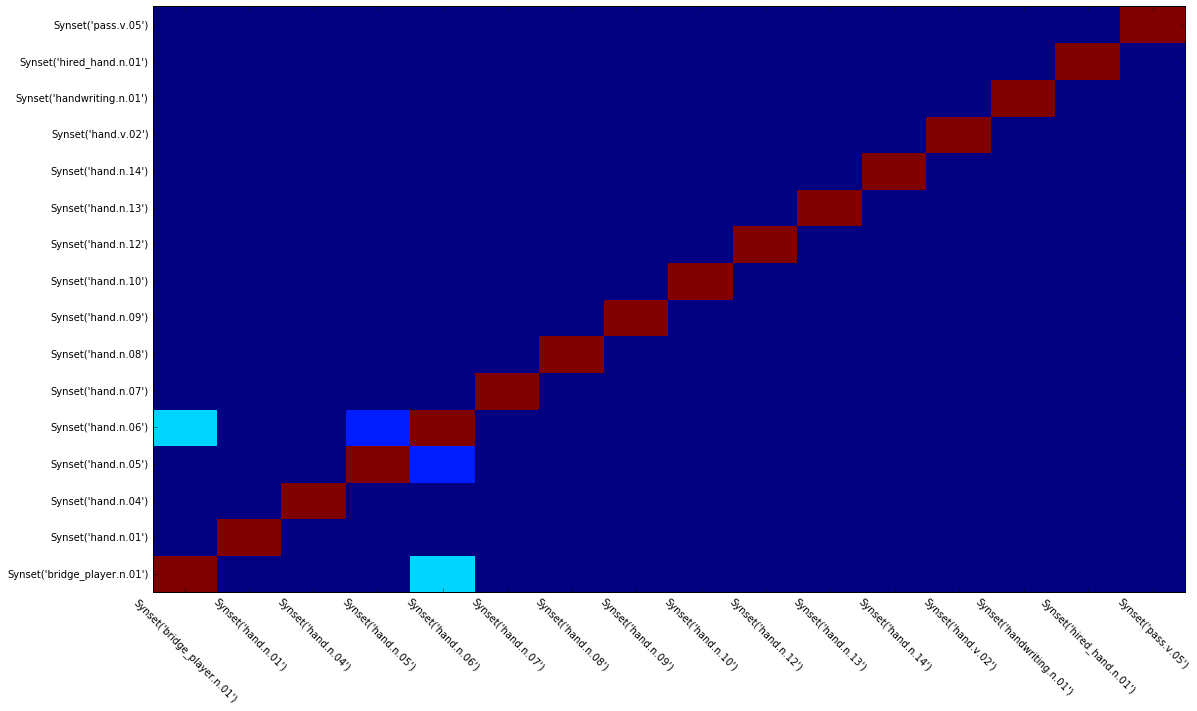

0.93369391025641024

In [183]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
fig.savefig('test2png.png', dpi=100)

#We are creating a metaphor index here:
numer = (((sum(sample_df.sum()))/2)) #this is summing all of the similarity scores, and dividing by 2 to remove any repeats (i.e., A-B == B=A)
denom = sum(sample_df.count())/2 #this is summing all of the possible similarity comparisons
meta_index_hand = numer/denom #those with small ratios are likely to have less similar glosses, or have the trite metaphor built into the definition
meta_index_hand = 1 - meta_index_hand #subtract from 1 to make it easier to read - scores ==1 are more metaphorical
meta_index_hand

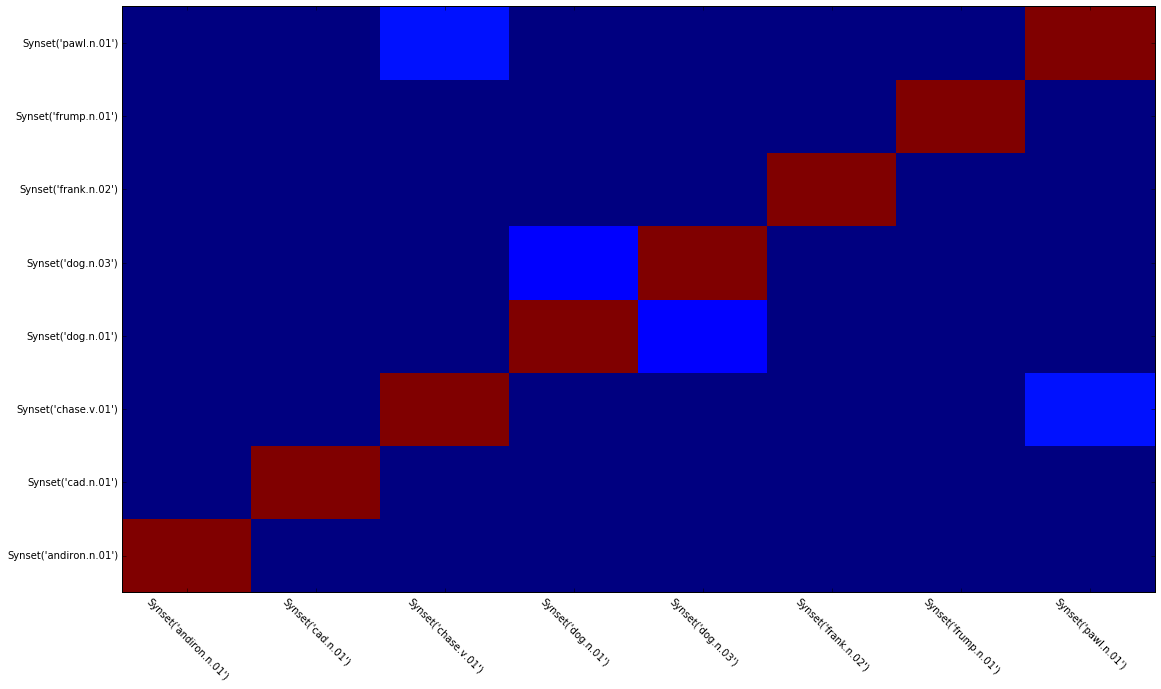

0.86706349206349209

In [184]:
l = defaultdict(dict)
a = wn.synsets('dog')
b = wn.synsets('dog')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_dog = numer/denom
meta_index_dog = 1 - meta_index_dog
meta_index_dog

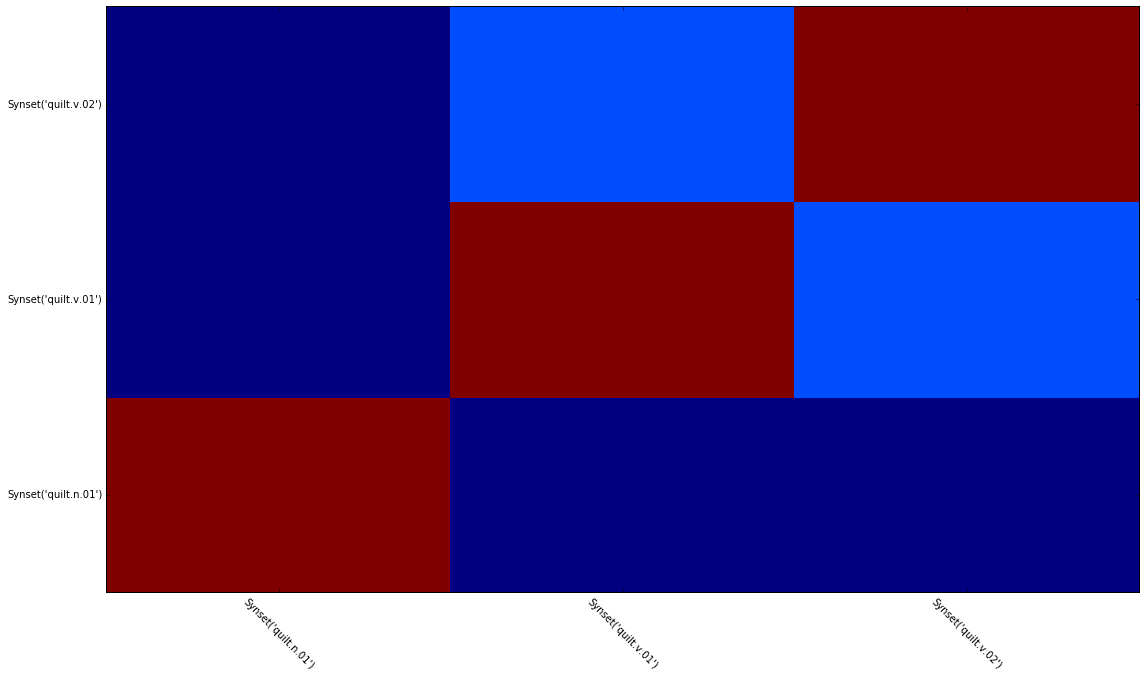

0.51851851851851838

In [185]:
l = defaultdict(dict)
a = wn.synsets('quilt')
b = wn.synsets('quilt')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_quilt = 1- numer/denom
meta_index_quilt

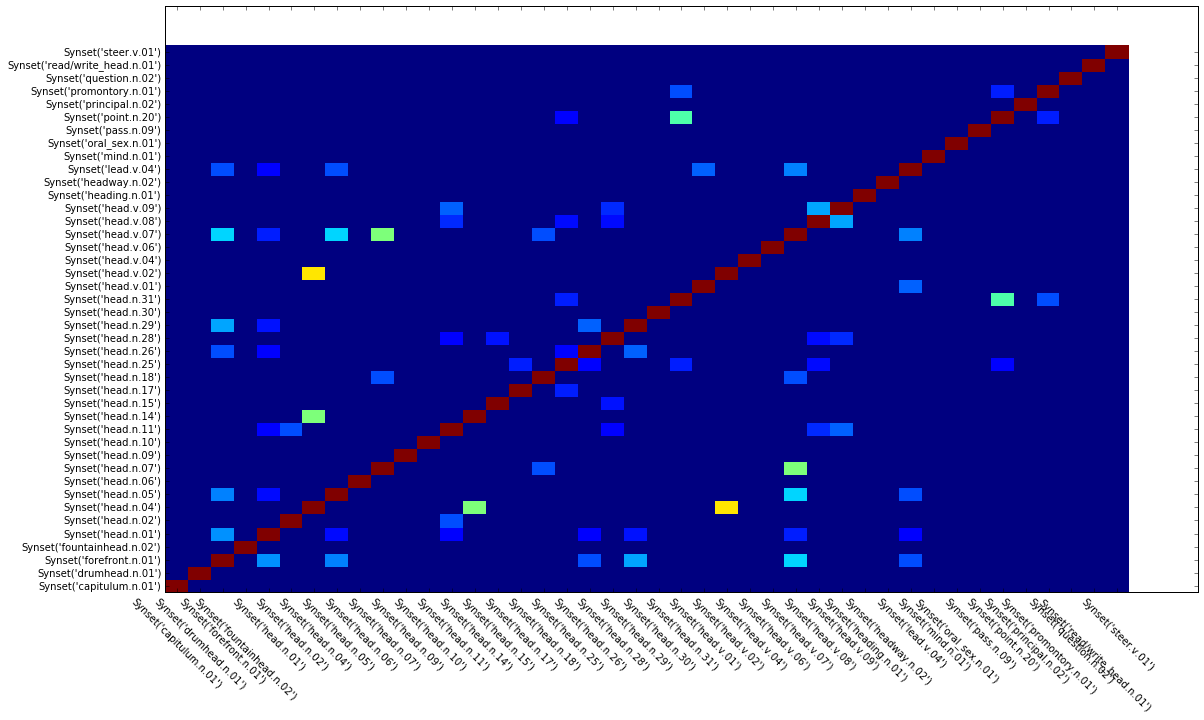

0.96651811314676461

In [186]:
l = defaultdict(dict)
a = wn.synsets('head')
b = wn.synsets('head')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_head = 1- numer/denom
meta_index_head

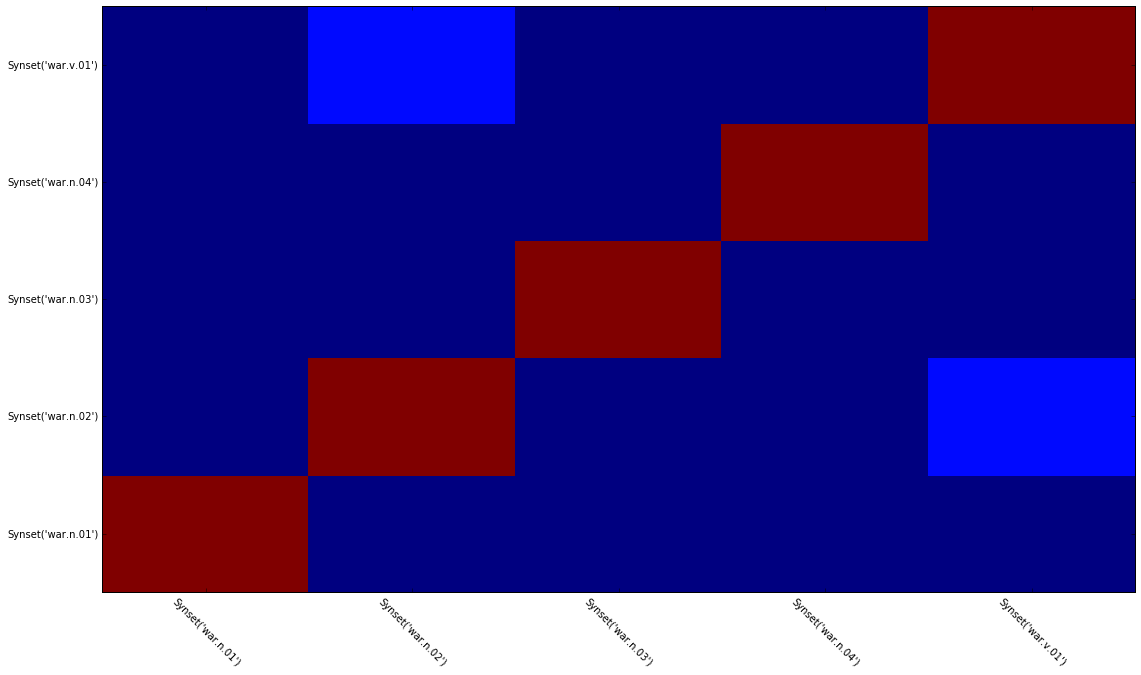

0.78933333333333333

In [187]:
l = defaultdict(dict)
a = wn.synsets('war')
b = wn.synsets('war')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_war = 1 - numer/denom
meta_index_war

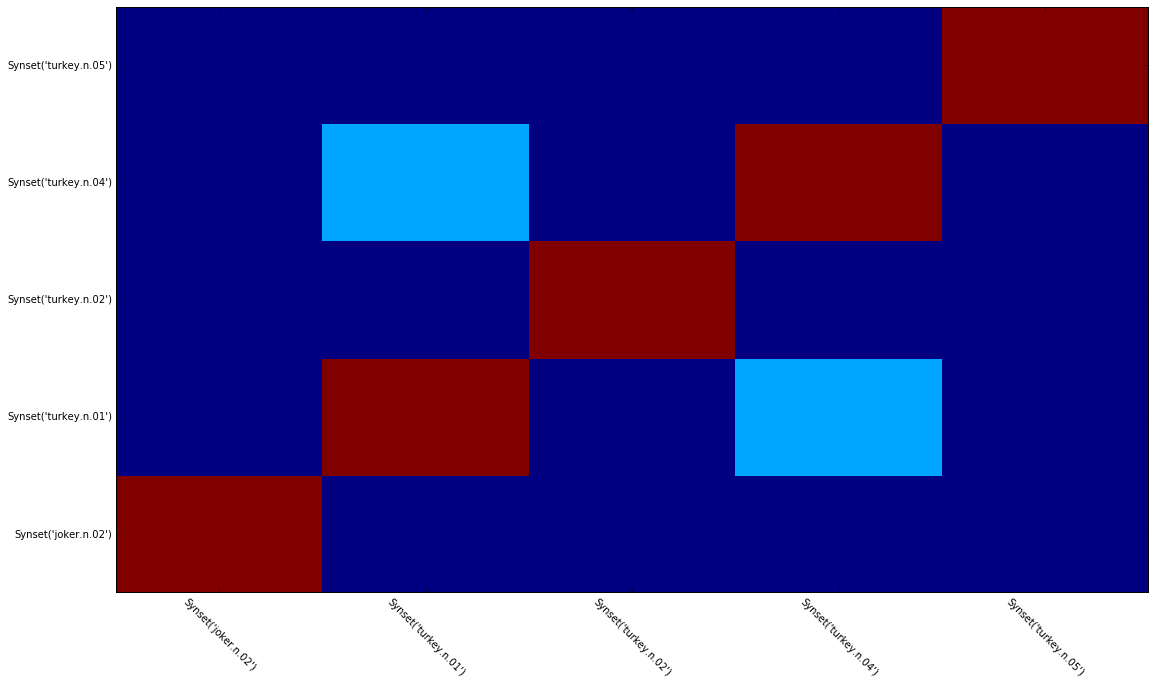

0.77714285714285714

In [188]:
l = defaultdict(dict)
a = wn.synsets('turkey')
b = wn.synsets('turkey')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_turkey = 1- numer/denom
meta_index_turkey

In [191]:
#Lets see the most frequently occurring words in metanet

from collections import Counter
sorted_metanet = df_metanet["sample"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
# df_metanet["sample"]
with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
    print(sorted_metanet.loc[sorted_metanet >= 15])

a               457.0
ability          16.0
action           35.0
addressing       16.0
along            27.0
amount           20.0
an               64.0
are             215.0
being            62.0
body             26.0
building         15.0
change           23.0
complex          21.0
control          37.0
disease          22.0
economic         51.0
election         18.0
force            17.0
government       98.0
government's     18.0
gun              38.0
guns             16.0
harm             25.0
ideas            20.0
impediments      43.0
improving        36.0
in               57.0
institution      26.0
is              969.0
location         38.0
machine          23.0
moral            16.0
motion           62.0
moving           18.0
nation           23.0
object           48.0
objects          23.0
of              169.0
on               16.0
path             37.0
physical        116.0
possession       15.0
poverty          15.0
problems         15.0
regulation       15.0
resource  

## Let's try looking up some of these frequently occuring words in metanet

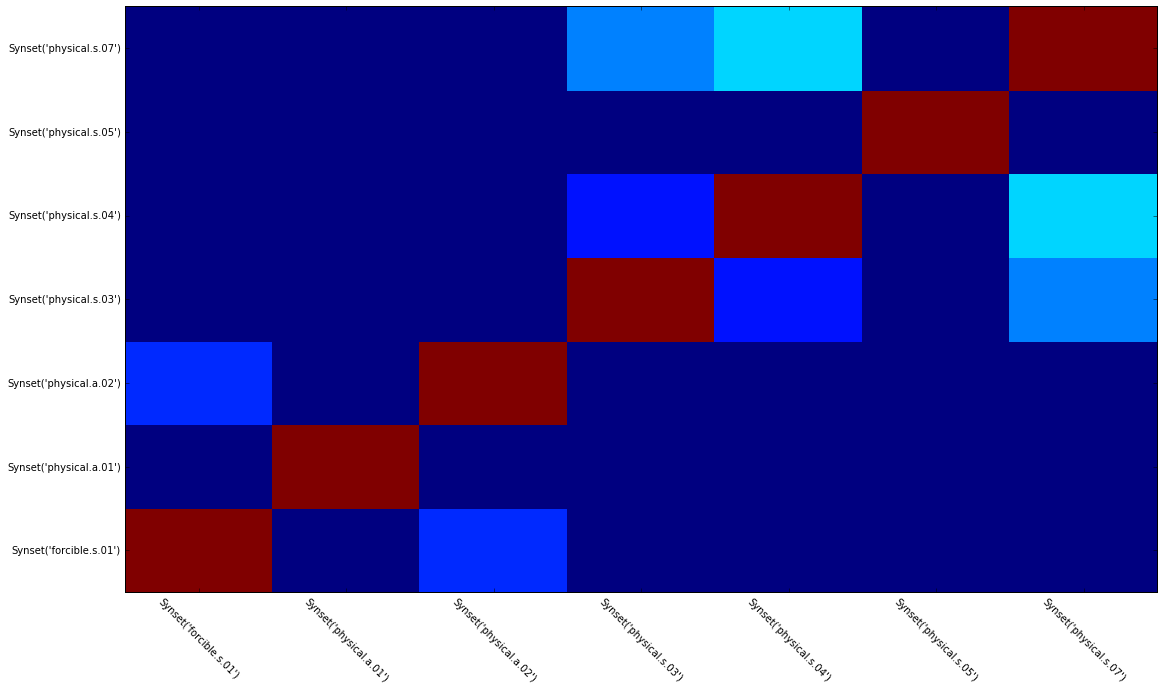

0.82069970845481044

In [192]:
l = defaultdict(dict)
a = wn.synsets('physical')
b = wn.synsets('physical')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer_physical = (((sum(sample_df.sum()))/2))
# print(numer_head)
denom_physical = sum(sample_df.count())/2
# print(denom_head)
meta_index_physical = 1- numer_physical/denom_physical
meta_index_physical

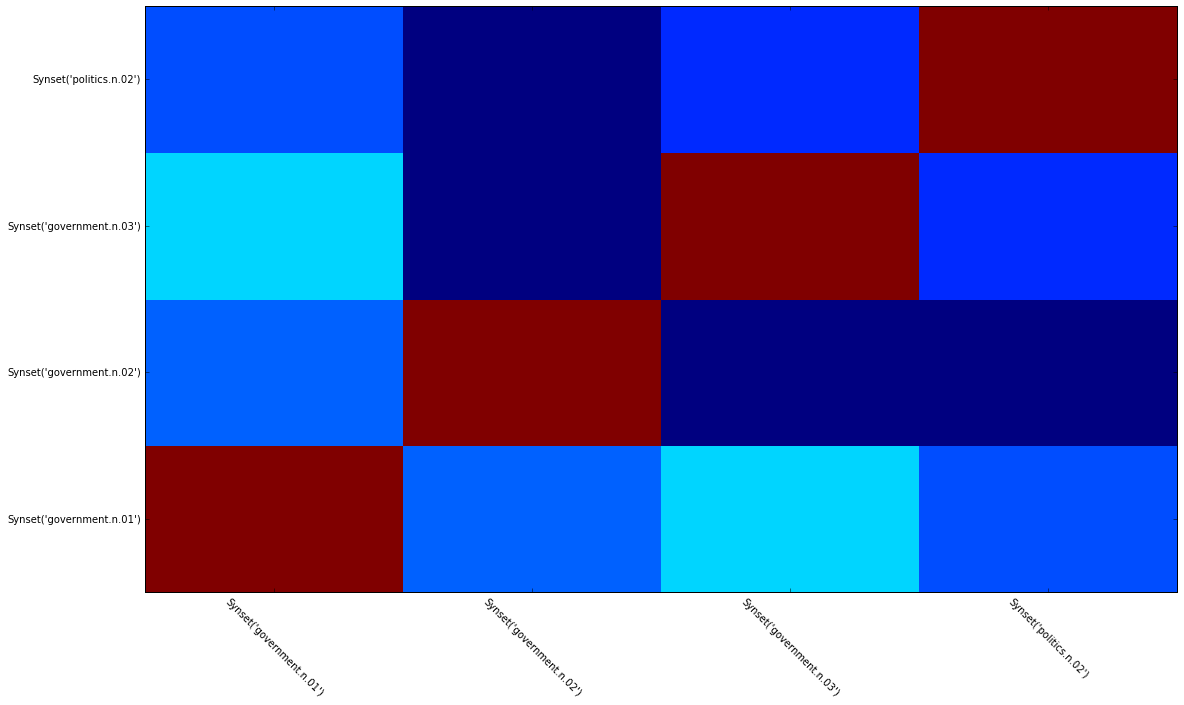

0.63472222222222219

In [193]:
l = defaultdict(dict)
a = wn.synsets('government')
b = wn.synsets('government')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_gov = 1- numer/denom
meta_index_gov

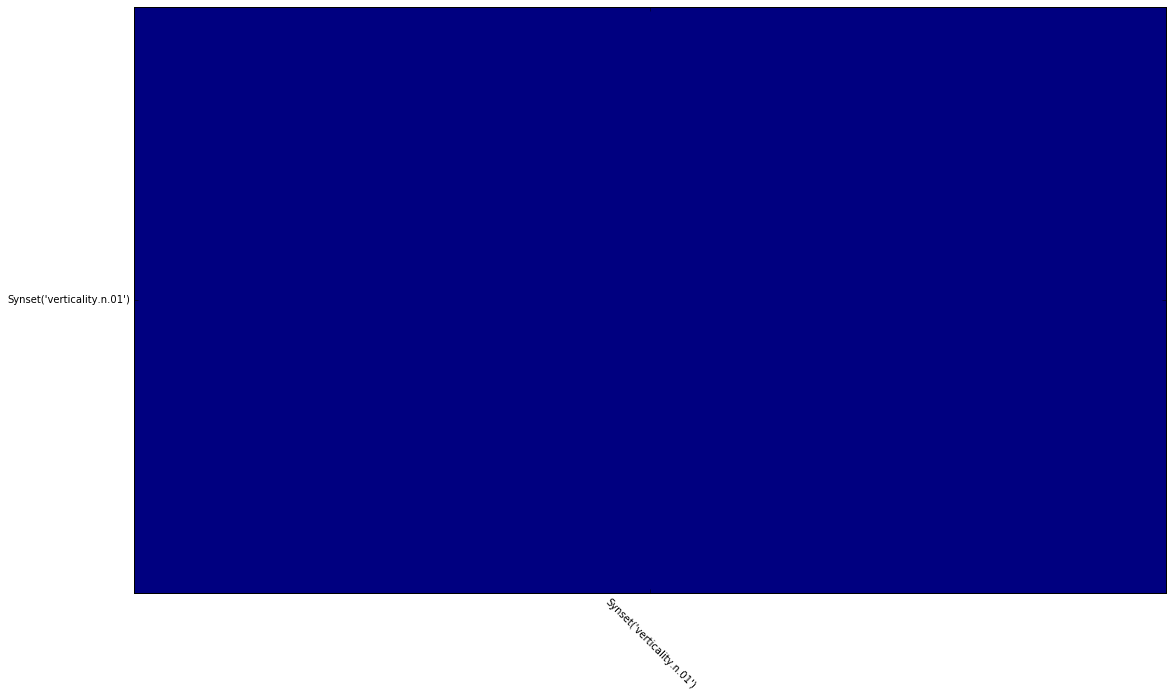

0.0

In [194]:
l = defaultdict(dict)
a = wn.synsets('verticality')
b = wn.synsets('verticality')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_verticality = 1- numer/denom
meta_index_verticality

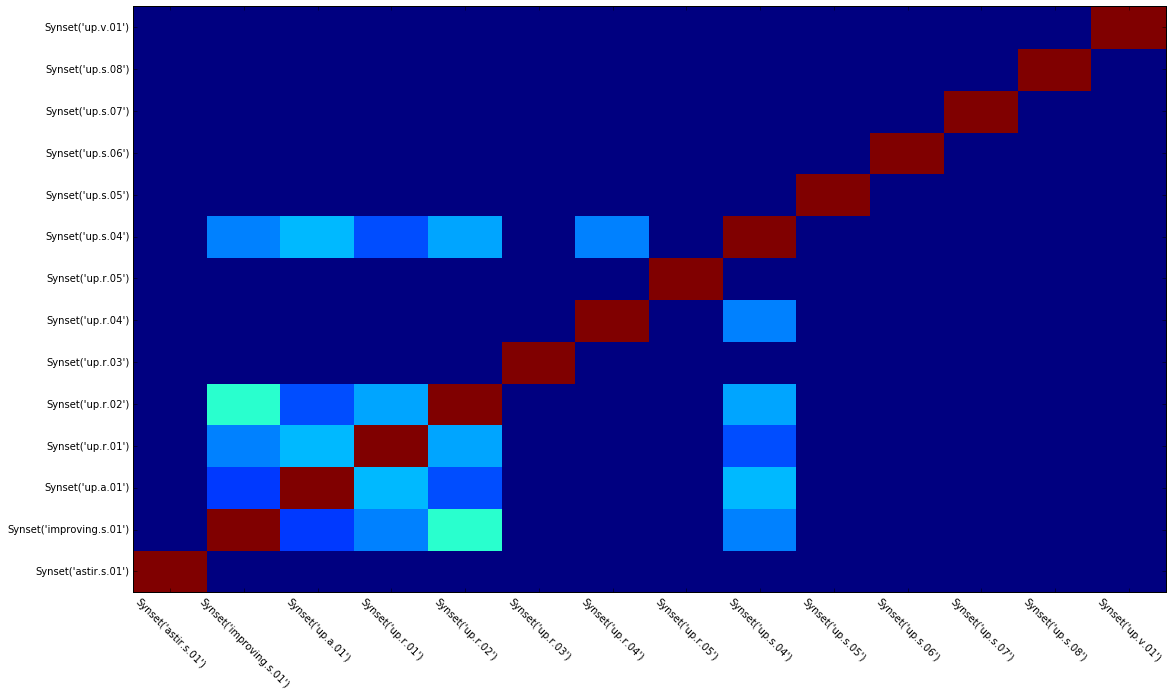

0.89878947583029212

In [195]:
l = defaultdict(dict)
a = wn.synsets('up')
b = wn.synsets('up')
for val in a:
    for val2 in b:
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
fig.savefig('test2png.png', dpi=100)
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_up = 1- numer/denom
meta_index_up

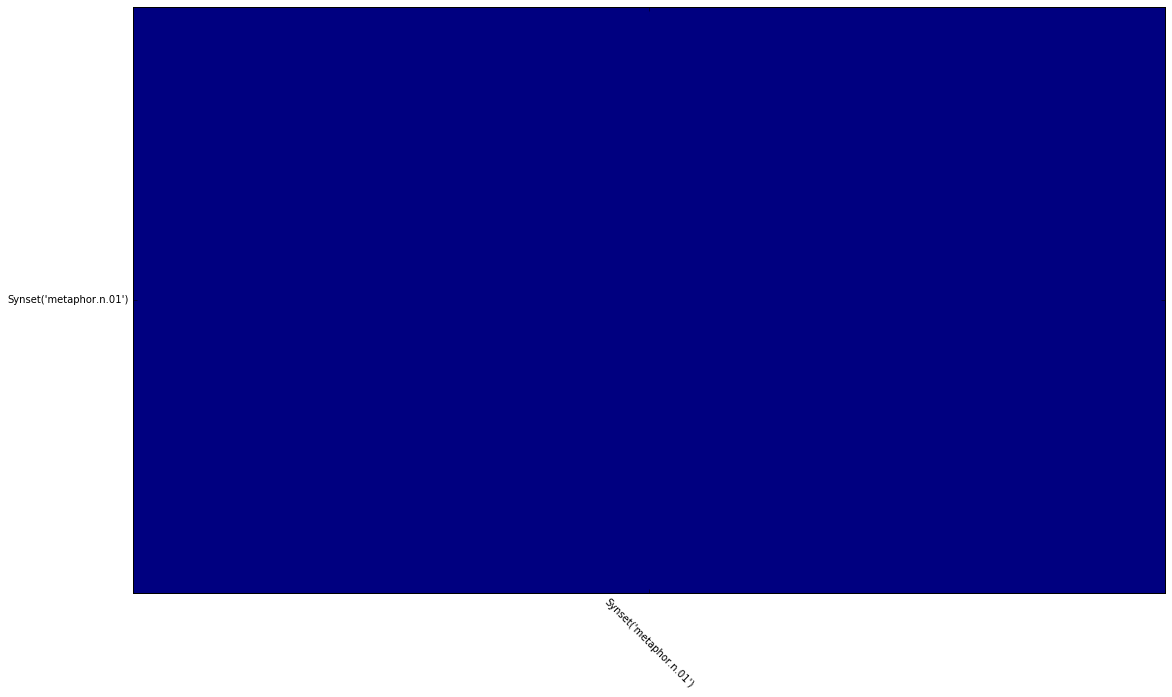

0.0

In [196]:
l = defaultdict(dict)
a = wn.synsets('metaphor')
b = wn.synsets('metaphor')
for val in a:
#     print(val)
    for val2 in b:
#         print(val.definition())
        val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
        val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
        l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
sample_df = pd.DataFrame.from_dict(l)
sample_df
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.pcolor(sample_df)
plt.yticks(np.arange(0.5, len(sample_df.index), 1), sample_df.index)
plt.xticks(np.arange(0.5, len(sample_df.columns), 1), sample_df.columns, rotation = -45)
plt.show()
numer = (((sum(sample_df.sum()))/2))
denom = sum(sample_df.count())/2
meta_index_metaphor = 1- numer/denom
meta_index_metaphor

In [197]:
print('meta_index_hand: ' + str(meta_index_hand))
print('meta_index_dog: ' + str(meta_index_dog))
print('meta_index_government: ' + str(meta_index_gov))
print('meta_index_quilt: ' + str(meta_index_quilt))
print('meta_index_head: ' + str(meta_index_head))
print('meta_index_war: ' + str(meta_index_war))
print('meta_index_turkey: ' + str(meta_index_turkey))
print('meta_index_physical: ' + str(meta_index_physical))
print('meta_index_verticality: ' + str(meta_index_verticality))
print('meta_index_up: ' + str(meta_index_up))
print('meta_index_metaphor: ' + str(meta_index_metaphor))

meta_index_hand: 0.933693910256
meta_index_dog: 0.867063492063
meta_index_government: 0.634722222222
meta_index_quilt: 0.518518518519
meta_index_head: 0.966518113147
meta_index_war: 0.789333333333
meta_index_turkey: 0.777142857143
meta_index_physical: 0.820699708455
meta_index_verticality: 0.0
meta_index_up: 0.89878947583
meta_index_metaphor: 0.0


In [198]:
with open("sciencearticle.txt", "r") as testset:
    filtered_words = []
    testmeta = []
    word_list = ''
    meta_index_dict = defaultdict(dict)
    for line in testset:
        word_list = line.split()
        filtered_words = [re.sub(r'[^\w\s]','',word.lower()) for word in word_list if word not in stopwords.words('english')]
        for index,word in enumerate(filtered_words):
            if index%100 == 0:
                print(index,len(filtered_words))
            l = defaultdict(dict)
            a = wn.synsets(word)
            b = wn.synsets(word)
            for val in a:
                for val2 in b:
                    val_comp = ' '.join([word for word in val.definition().split() if word not in stopwords.words("english")])
                    val2_comp = ' '.join([word for word in val2.definition().split() if word not in stopwords.words("english")])
                    l[val][val2] = SequenceMatcher(None, val_comp.split(), val2_comp.split()).ratio()
            sample_df = pd.DataFrame.from_dict(l)
#                 sample_df
            numer = (((sum(sample_df.sum()))/2))
            denom = sum(sample_df.count())/2
            if denom != 0:
                meta_index = 1- numer/denom
                meta_index_dict[word] = meta_index
                if meta_index >= 0.90:
                    testmeta.append(word)

0 7
0 4
0 12
0 18
0 23
0 41
0 26
0 37
0 38
0 41
0 45
0 43
0 39
0 22
0 40
0 72
0 75


['showing', 'words', 'words', 'words', 'white', 'build', 'shows', 'represented', 'case', 'words', 'jack', 'holds', 'word', 'spot', 'number', 'words', 'word', 'lights', 'spots', 'make', 'represent', 'word', 'use', 'light', 'force', 'involved', 'study', 'advances', 'fields', 'approach', 'words', 'hearing', 'reading', 'even', 'thinking', 'first', 'study', 'use', 'show', 'matched', 'show', 'words', 'spots', 'short', 'words', 'hearing', 'words', 'words', 'lay', 'shows', 'words', 'exercise', 'side', 'represents', 'word', 'killed', 'side', 'top', 'head', 'spots', 'word', 'represented', 'spot', 'words', 'part', 'word', 'top', 'words', 'word', 'top', 'numbers', 'buildings', 'places', 'words', 'way', 'study', 'piece', 'represent', 'numbers', 'represented', 'work', 'new', 'show', 'holds', 'proved', 'come', 'set', 'get', 'right', 'set', 'work', 'studies', 'word', 'light', 'worked', 'step', 'words', 'thinking', 'use', 'see', 'touching', 'head', 'force', 'form', 'word', 'take', 'word', 'things', 'ma

{'advances',
 'approach',
 'build',
 'buildings',
 'case',
 'come',
 'even',
 'exercise',
 'fields',
 'first',
 'force',
 'form',
 'get',
 'head',
 'hearing',
 'heavy',
 'holds',
 'involved',
 'jack',
 'killed',
 'lay',
 'light',
 'lights',
 'lost',
 'made',
 'make',
 'matched',
 'new',
 'number',
 'numbers',
 'part',
 'piece',
 'places',
 'proved',
 'reading',
 'represent',
 'represented',
 'represents',
 'right',
 'see',
 'set',
 'short',
 'show',
 'showing',
 'shows',
 'side',
 'spot',
 'spots',
 'step',
 'still',
 'studies',
 'study',
 'take',
 'things',
 'thinking',
 'top',
 'touching',
 'use',
 'way',
 'white',
 'word',
 'words',
 'work',
 'worked'}

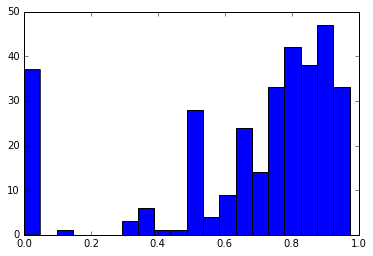

In [199]:
print(testmeta)
print(len(testmeta))

values_to_plot = list(meta_index_dict.values())
matplotlib.pyplot.hist(values_to_plot, bins=20)

sample_run_set = set(testmeta)
len(sample_run_set)
sample_run_set

We now have a way to see how "metaphorical" a word is based on if it has very dissimilar glosses. If it has many dissimilar glosses, it will probably have one of the metaphorical glosses captured, so it will be a trite metaphor. Here are a list of words that are "more metaphorical" than others.

## Sources:
##### A lot of this code was from the NLP 256 Course, written by Andrea Gagliano and Marti Hearst
##### Tsvetko "Metaphor Detection with Cross-Lingual Model Transfer": http://www.cs.cmu.edu/~ytsvetko/papers/metaphor-acl14.pdf
##### .txt of Adj-N and S-V-Obj: https://github.com/ytsvetko/metaphor 
##### High-level metaphor categories: https://metaphor.icsi.berkeley.edu/pub/en/index.php/Category:Metaphor
##### Metaphor Examples for Kids: http://examples.yourdictionary.com/metaphor-examples-for-kids.html
##### Sample science paper: https://www.theguardian.com/science/2016/apr/27/brain-atlas-showing-how-words-are-organised-neuroscience